In [1]:
import pandas as pd
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from PIL import Image
import scripts.utils as sc_ut

c:\Users\79267\Documents\DLE\s4_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Проведите исследовательский анализ (EDA)

In [2]:
ingredients = pd.read_csv('data/ingredients.csv')
print('Размер: ',ingredients.shape)
print(ingredients.head(10))
ingredients['id'] = 'ingr_' + ingredients.id.astype(str).str.zfill(10)

Размер:  (555, 2)
   id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes
5   6    caesar salad
6   7     cauliflower
7   8  scrambled eggs
8   9       wild rice
9  10           steak


In [2]:
dish = pd.read_csv('data/dish.csv')
print('Размер: ',dish.shape)
print(dish.head(10))

Размер:  (3262, 5)
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   
5  dish_1565640549       45.482903       139.0   
6  dish_1563207364      309.269989       271.0   
7  dish_1561575474      120.058434       183.0   
8  dish_1563216717      246.007996       332.0   
9  dish_1565972591      195.199997       122.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train  
5  ingr_0000000032;ingr_0000000523;ingr_000000016...  trai

In [31]:
unique_ingredient_train = []
for elem in dish.loc[dish.split =='train','ingredients']:
    unique_ingredient_train.extend(elem.split(';'))
unique_ingredient_train = set(unique_ingredient_train)
print('Уникальные ингредиенты в трейне:', len(unique_ingredient_train))

unique_ingredient_test = []
for elem in dish.loc[dish.split =='test','ingredients']:
    unique_ingredient_test.extend(elem.split(';'))
unique_ingredient_test = set(unique_ingredient_train)
print('Уникальные ингредиенты в тесте:', len(unique_ingredient_test))

print('Разница между ингредиентами отсутствует:', len(unique_ingredient_train.difference(unique_ingredient_test)), 
    len(unique_ingredient_test.difference(unique_ingredient_train)))

Уникальные ингредиенты в трейне: 198
Уникальные ингредиенты в тесте: 198
Разница между ингредиентами отсутствует: 0 0


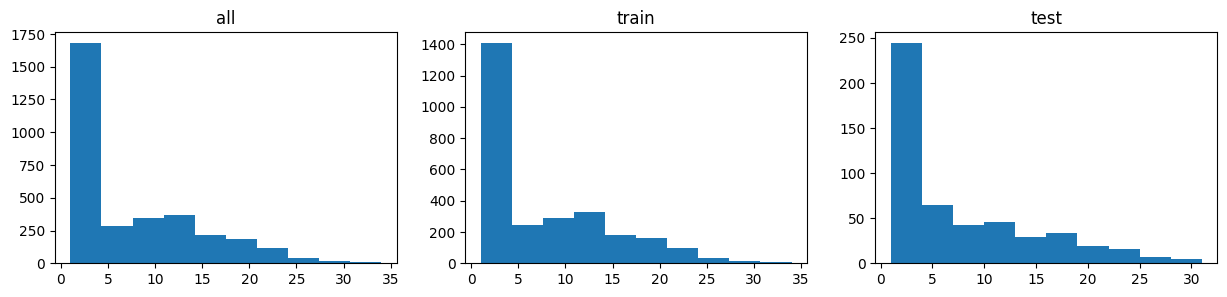

In [29]:
plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
plt.hist(dish.ingredients.apply(lambda x: len(x.split(';'))))
plt.title('all') 

plt.subplot(1, 3, 2)
plt.hist(dish[dish.split =='train'].ingredients.apply(lambda x: len(x.split(';'))))
plt.title('train') 

plt.subplot(1, 3, 3)
plt.hist(dish[dish.split =='test'].ingredients.apply(lambda x: len(x.split(';'))))
plt.title('test') 
plt.show()

dish_1556573514
dish_1556575014
dish_1556575083
dish_1556575124
dish_1556575273
dish_1556575327
dish_1556575386
dish_1556575446
dish_1556575499
dish_1556575558


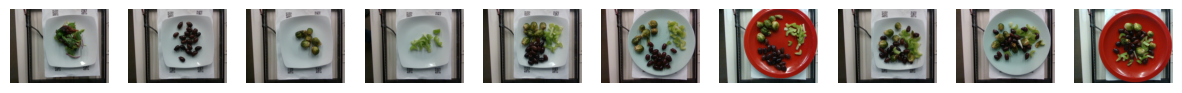

In [10]:
dataset_path = 'data/images'
dataset = ImageFolder(dataset_path)
# Визуализация датасета до трансформаций
fig = plt.figure(figsize=(15,6))
for index in range (1, 11):
    image, label = dataset[index]
    print(dataset.classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image)
    plt.axis('off')

In [17]:
print('Фотографии в наличии по всем блюдам: ', dish.shape[0]==dish[dish.dish_id.isin(dataset.classes)].shape[0])

Фотографии в наличии по всем блюдам:  True


> Как вы будете решать задачу?

* Использую мультимодальную сеть. Сохраню архитектуру из предыдущих уроков, хотя можно облегчить текстовую модель, так как контекст не важен. Добавлю total_mass, как дополнительный признак для финального блока, если бы были еще какие-нибудь признаки, возможно можно было бы добавить отдельную подмодель для построение сети на табличных данных. Регрессионный слой начну с простого полносвязанного слоя, но можно будет добавить промежуточный слой, для постепенного понижения размерности.

>Какие подходы к обогащению/аугментации данных примените и почему?

* Случайное вырезание квадрата, вращение изображения, аффинное преобразование, изменение цвета.
* Дропаут и работа с цветовыми каналами не стал делать, кажется, что некоторые продукты могут пропасть из изображения, а так же изображения делались под одним ракурсом и на одно устройство.

> На какие метрики будете ориентироваться при обучении?

* Основную MAE, так же добавил MSE.

# Этап 2. Реализуйте пайплайн обучения

* scripts/utils.py
* scripts/dataset.py

In [3]:
class Config:
    SEED = 42

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = 'resnet50.a1_in1k'

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "layer4"

    BATCH_SIZE = 32
    TEXT_LR = 1e-4
    IMAGE_LR = 1e-4
    REGRES_LR = 1e-3
    EPOCHS = 12
    HIDDEN_DIM = 256

    IMAGE_PATH = "data/images/"
    DF_GENERAL_PATH = "data/dish.csv"
    DF_PRODUCT_PATH = "data/ingredients.csv"
    SAVE_PATH = "best_model.pth"
config = Config()

# Этап 3. Обучение модели

In [13]:
sc_ut.train(config, 'cpu')

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

* Лучший результат получился на 10 эпохе (MAE 47.3), можно продолжить обучать модель, попробовать с разными гиперпараметрами.
* Модель best_model.pth

# Этап 4. Валидация качества

In [4]:
inference = sc_ut.inference(config, 'cpu', type_ds = 'val')#cuda
inference

,target,result,dish_id
0,300.794281,277.988068,dish_1561662216
1,382.936646,504.885864,dish_1562008979
2,274.190002,198.710419,dish_1561739238
3,419.681702,350.281281,dish_1562691032
4,2.300000,1.182145,dish_1558549773
...,...,...,...
22,109.061714,115.676239,dish_1562690950
23,331.000000,320.536835,dish_1558461792
24,246.864426,207.463959,dish_1562700568
25,153.204697,168.310913,dish_1564686966


In [5]:
print('Константный прогноз относительно среднего: ', (inference.target - inference.target.mean()).abs().mean())

Константный прогноз относительно среднего:  168.57834


In [6]:
inference['abs_error'] = (inference['result'] - inference['target']).abs()

In [12]:
print('MAE: ', mean_absolute_error(inference.target, inference.result))
print('RMSE', root_mean_squared_error(inference.target, inference.result))

MAE:  47.302303314208984
RMSE 74.47332000732422


In [8]:
inference.sort_values(['abs_error'], ascending=False)

,target,result,dish_id,abs_error
13,902.200012,516.221558,dish_1565811139,385.978455
10,508.048981,173.832779,dish_1566501594,334.216187
10,781.958008,470.791473,dish_1558549806,311.166534
31,467.613037,752.131409,dish_1559849466,284.518372
3,901.810059,630.858093,dish_1566328776,270.951965
...,...,...,...,...
24,3.280000,3.388898,dish_1558641200,0.108898
9,132.919037,133.022903,dish_1566502472,0.103867
28,117.318321,117.229713,dish_1561662190,0.088608
21,39.930000,39.867622,dish_1567007751,0.062378


In [9]:
list_bad = inference.sort_values(['abs_error'], ascending=False).head(5).dish_id.to_list()
list_good = inference.sort_values(['abs_error'], ascending=True).head(5).dish_id.to_list()

Плохо определены


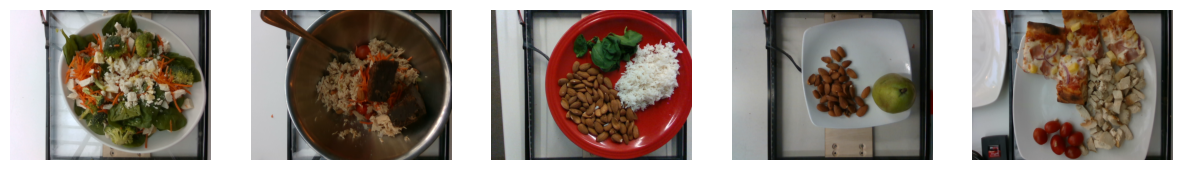

In [ ]:
print('Плохо определены')
fig = plt.figure(figsize=(15,6))
for index, id in zip(range (1, 6), list_bad):
    plt.subplot(1, 5, index)
    plt.imshow(Image.open(config.IMAGE_PATH + f"{id}/rgb.png").convert('RGB'))
    plt.axis('off')

* Плохо определены высококалорийные продукты, причины могут состоять в том, что модель на обучение не смогла выделить такие продукты из смеси ингредиентов.

Хорошо определены


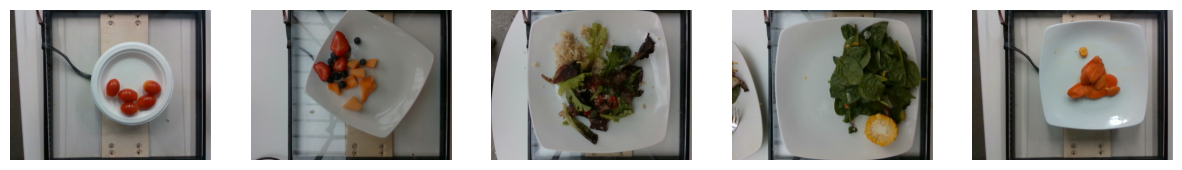

In [ ]:
print('Хорошо определены')
fig = plt.figure(figsize=(15,6))
for index, id in zip(range (1, 6), list_good):
    plt.subplot(1, 5, index)
    plt.imshow(Image.open(config.IMAGE_PATH + f"{id}/rgb.png").convert('RGB'))
    plt.axis('off')

* Модель хорошо справляется с опредлением на овощной/травяной продукции.